In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc as pm
from pymc.ode import DifferentialEquation

from itertools import product
import os.path as osp
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
import time
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display as print
from datetime import datetime
from scipy.integrate import odeint

# import sunode
import pickle

from core_lib import MyDataset, get_model, get_dcdts_for_solve_ivp, get_dcdts_for_scipy_odeint, plot_dataset
from core_lib import distance_func, MY_EPSILON,get_model2


In [2]:
db_csv_path = "dataset/data.csv"
idata_save_path = "runtime/pts/odes-exp04-idata-4-number-1core-halfnormsco-halfnormks-from-core.py-success.dt"

dataset_ori = MyDataset(db_csv_path)
df_ori = dataset_ori.get_df()
cct_names, error_names = dataset_ori.get_var_col_names()
c0 = df_ori[cct_names].iloc[0].values


/Users/izhangxm/WorkStation/VSCode/N15Tracing/core_lib/data.py:247: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


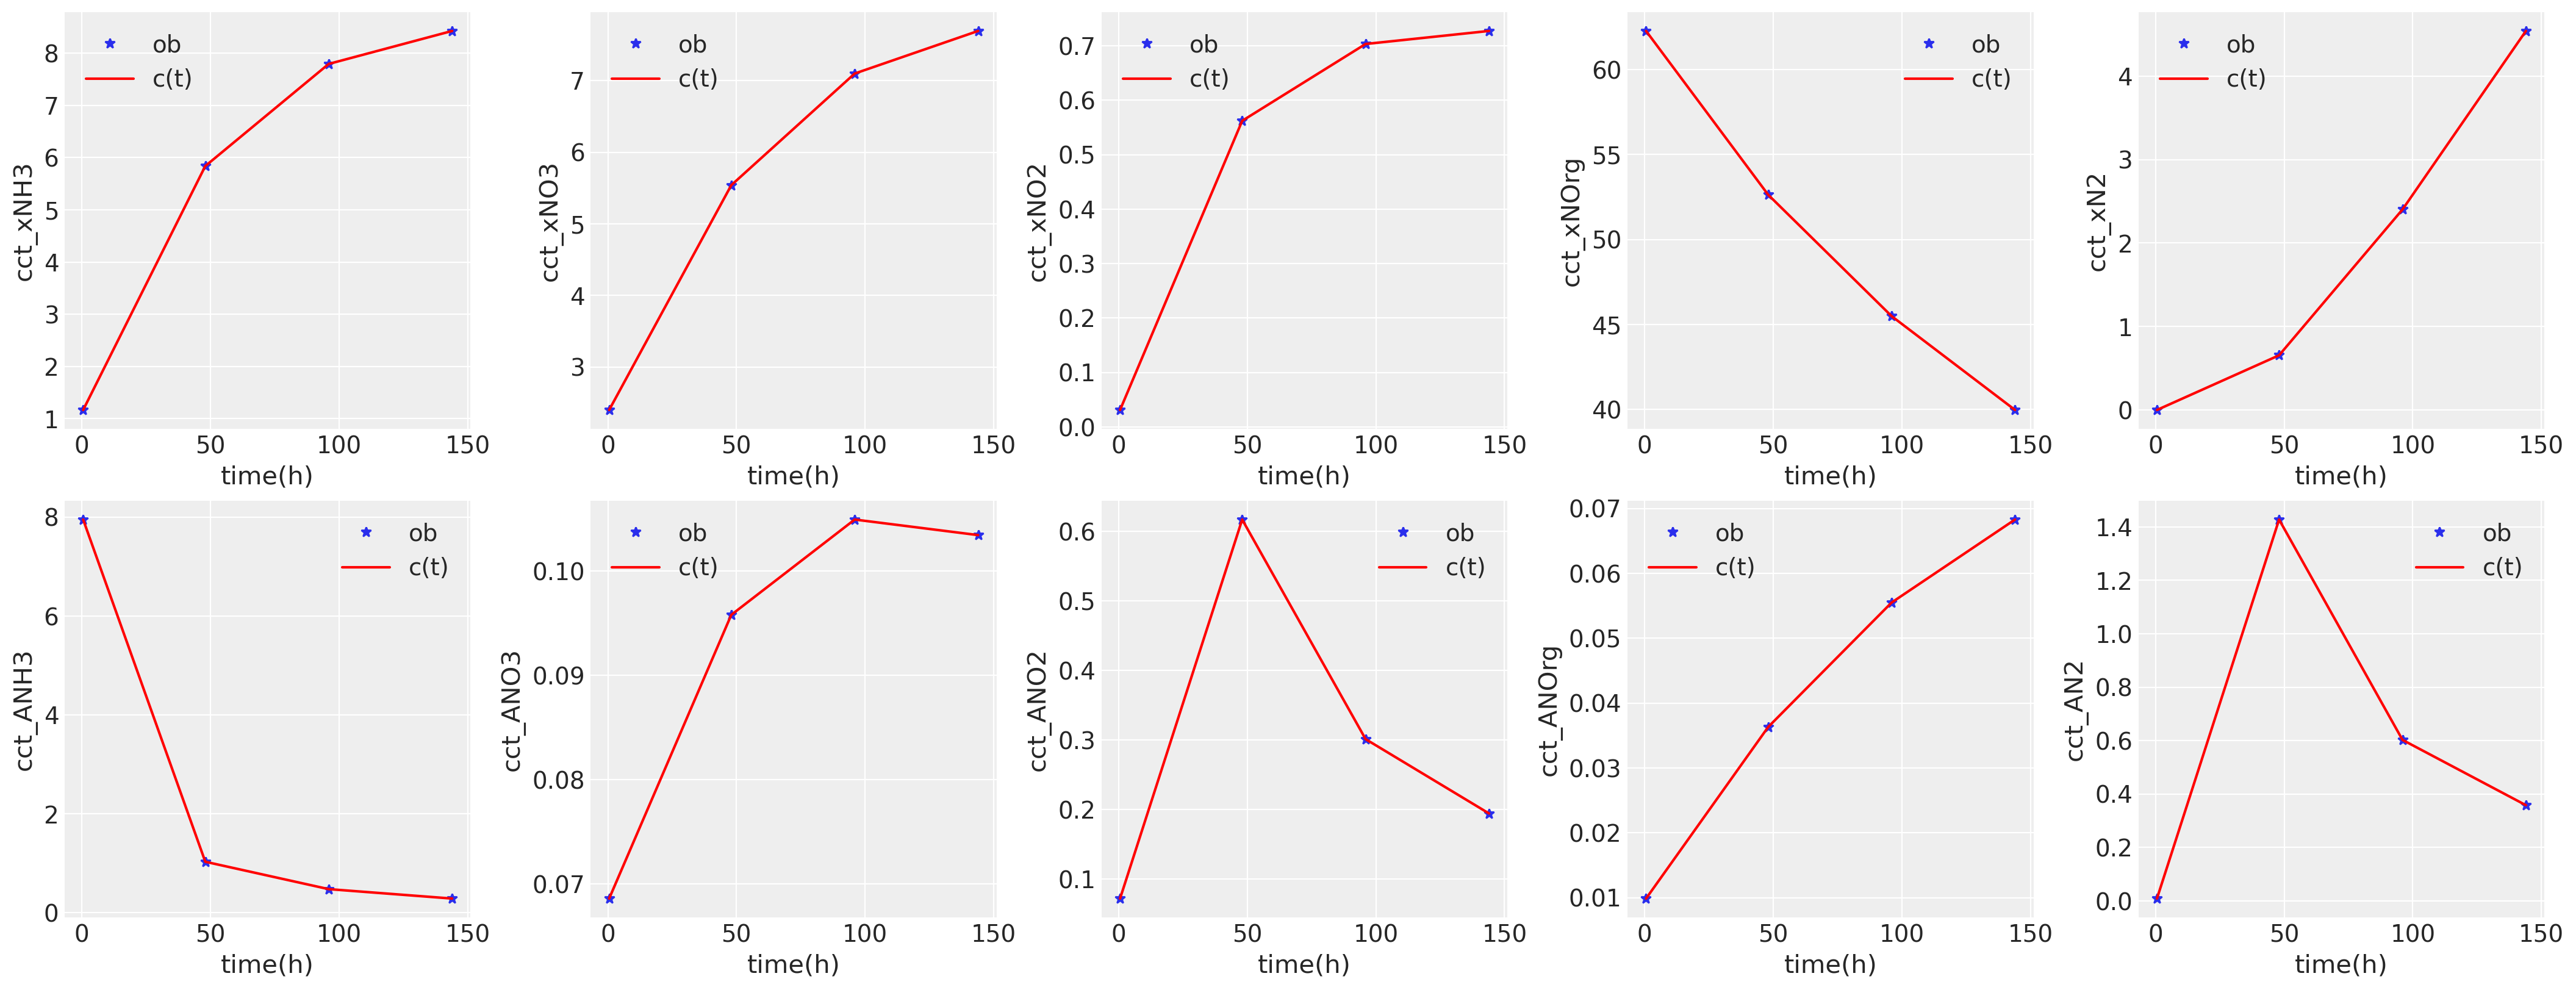

In [3]:
# 假设都是一级动力学
k_kinetics = np.repeat(1, 11).astype(np.uint8) 
# k_kinetics = np.array([0,0,0,0,1,1,0,0,1,1,0]).astype(np.uint8) 
ks = np.array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299, 0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432, 0.00177611])
#  =======================================================

# t_eval = np.linspace(0.5, 150, 8)
t_eval = np.array([0.5, 48, 96, 144])

dataset = MyDataset(db_csv_path)
df = dataset.get_df()
cct_names, error_names = dataset.get_var_col_names()
c0 = df[cct_names].iloc[0].values
dataset.set_as_sim_dataset(t_eval, c0, args=(ks, k_kinetics))
df = dataset.get_df()

plot_dataset(dataset, dataset)

In [4]:
# def get_model2(dataset, t_eval, k_kinetics, k_sigma_priors=0.01, kf_type=0):
mcmc_model = get_model(dataset, t_eval, k_kinetics, distance=distance_func, epsilon=MY_EPSILON, k_sigma_priors=0.01, kf_type=0)
# mcmc_model = get_model2(dataset, t_eval, k_kinetics, k_sigma_priors=0.01, kf_type=0)


[xNH3_s, xNO3_s, xNO2_s, xNOrg_s, xN2_s, ANH3_s, ANO3_s, ANO2_s, ANOrg_s, AN2_s]


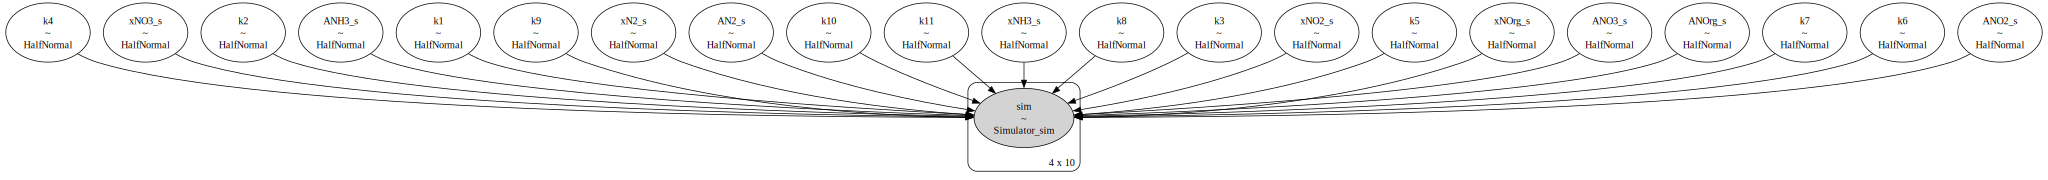

In [5]:
# print(get_format_time(),idata_save_path)
# print(ks, c0)
pm.model_to_graphviz(mcmc_model)

In [9]:
# print(idata_save_path)
print(pm.__version__)
idata_lv = pickle.load(open(idata_save_path, 'rb'))

# idata_lv = pm.sample_smc(draws=2000, chains=1, model=mcmc_model, progressbar=True)
# idata_lv = pm.sample(draws=2000, chains=2, model=mcmc_model, progressbar=True)
# pickle.dump(idata_lv,open(idata_save_path, 'wb'))

# idata_lv = pickle.load(open("runtime/2-idata.dt", 'rb'))
# Inference button (TM)!
import pymc.sampling.jax as pmjax
with mcmc_model:
    hierarchical_trace_jax = pmjax.sample_numpyro_nuts(2000, tune=2000, target_accept=0.9)


'5.3.1'

Compiling...


ValueError: Graph contains shared RandomType variables which cannot be safely replaced

In [8]:
# az.plot_trace(idata_lv, kind="rank_vlines");
df[cct_names]

,xNH3,xNO3,xNO2,xNOrg,xN2,ANH3,ANO3,ANO2,ANOrg,AN2
0,1.166667,2.398810,0.031100,62.285000,0.000071,7.948635,0.068579,0.072310,0.009857,0.008320
1,5.837087,5.539301,0.562177,52.633247,0.654953,1.032210,0.095807,0.616771,0.036312,1.427762
2,7.792909,7.098859,0.703303,45.482155,2.402246,0.478821,0.104952,0.301327,0.055499,0.602520
3,8.424422,7.693928,0.727245,39.954070,4.541027,0.288168,0.103458,0.194543,0.068299,0.357938


In [16]:
print(az.summary(idata_lv, round_to=10))
print(ks)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k1,0.002074,0.001022,0.000596,0.004001,0.000028,0.000021,1359.523400,1213.235730,NaN
k2,0.003326,0.000529,0.002369,0.004290,0.000014,0.000010,1486.894946,1268.484512,NaN
k3,0.008989,0.005034,0.001310,0.017940,0.000143,0.000101,1255.741010,890.149866,NaN
k4,0.004681,0.000690,0.003261,0.005939,0.000019,0.000014,1423.369553,965.025272,NaN
k5,0.006075,0.002511,0.002028,0.010483,0.000061,0.000043,1623.164371,1417.156539,NaN
k6,0.008510,0.000935,0.006816,0.010236,0.000024,0.000017,1530.088944,1770.836459,NaN
k7,0.002647,0.001150,0.000815,0.004666,0.000031,0.000022,1440.716664,1148.731406,NaN
k8,0.004539,0.002248,0.001353,0.008968,0.000061,0.000045,1441.210215,901.162048,NaN
k9,0.004315,0.000466,0.003450,0.005148,0.000011,0.000008,1747.260065,1575.396310,NaN
k10,0.002138,0.000221,0.001739,0.002558,0.000006,0.000004,1582.632439,1042.087330,NaN


array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299,
       0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432,
       0.00177611])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


'r2_loss'

0.9998407156726717

/Users/izhangxm/WorkStation/VSCode/N15Tracing/core_lib/data.py:247: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


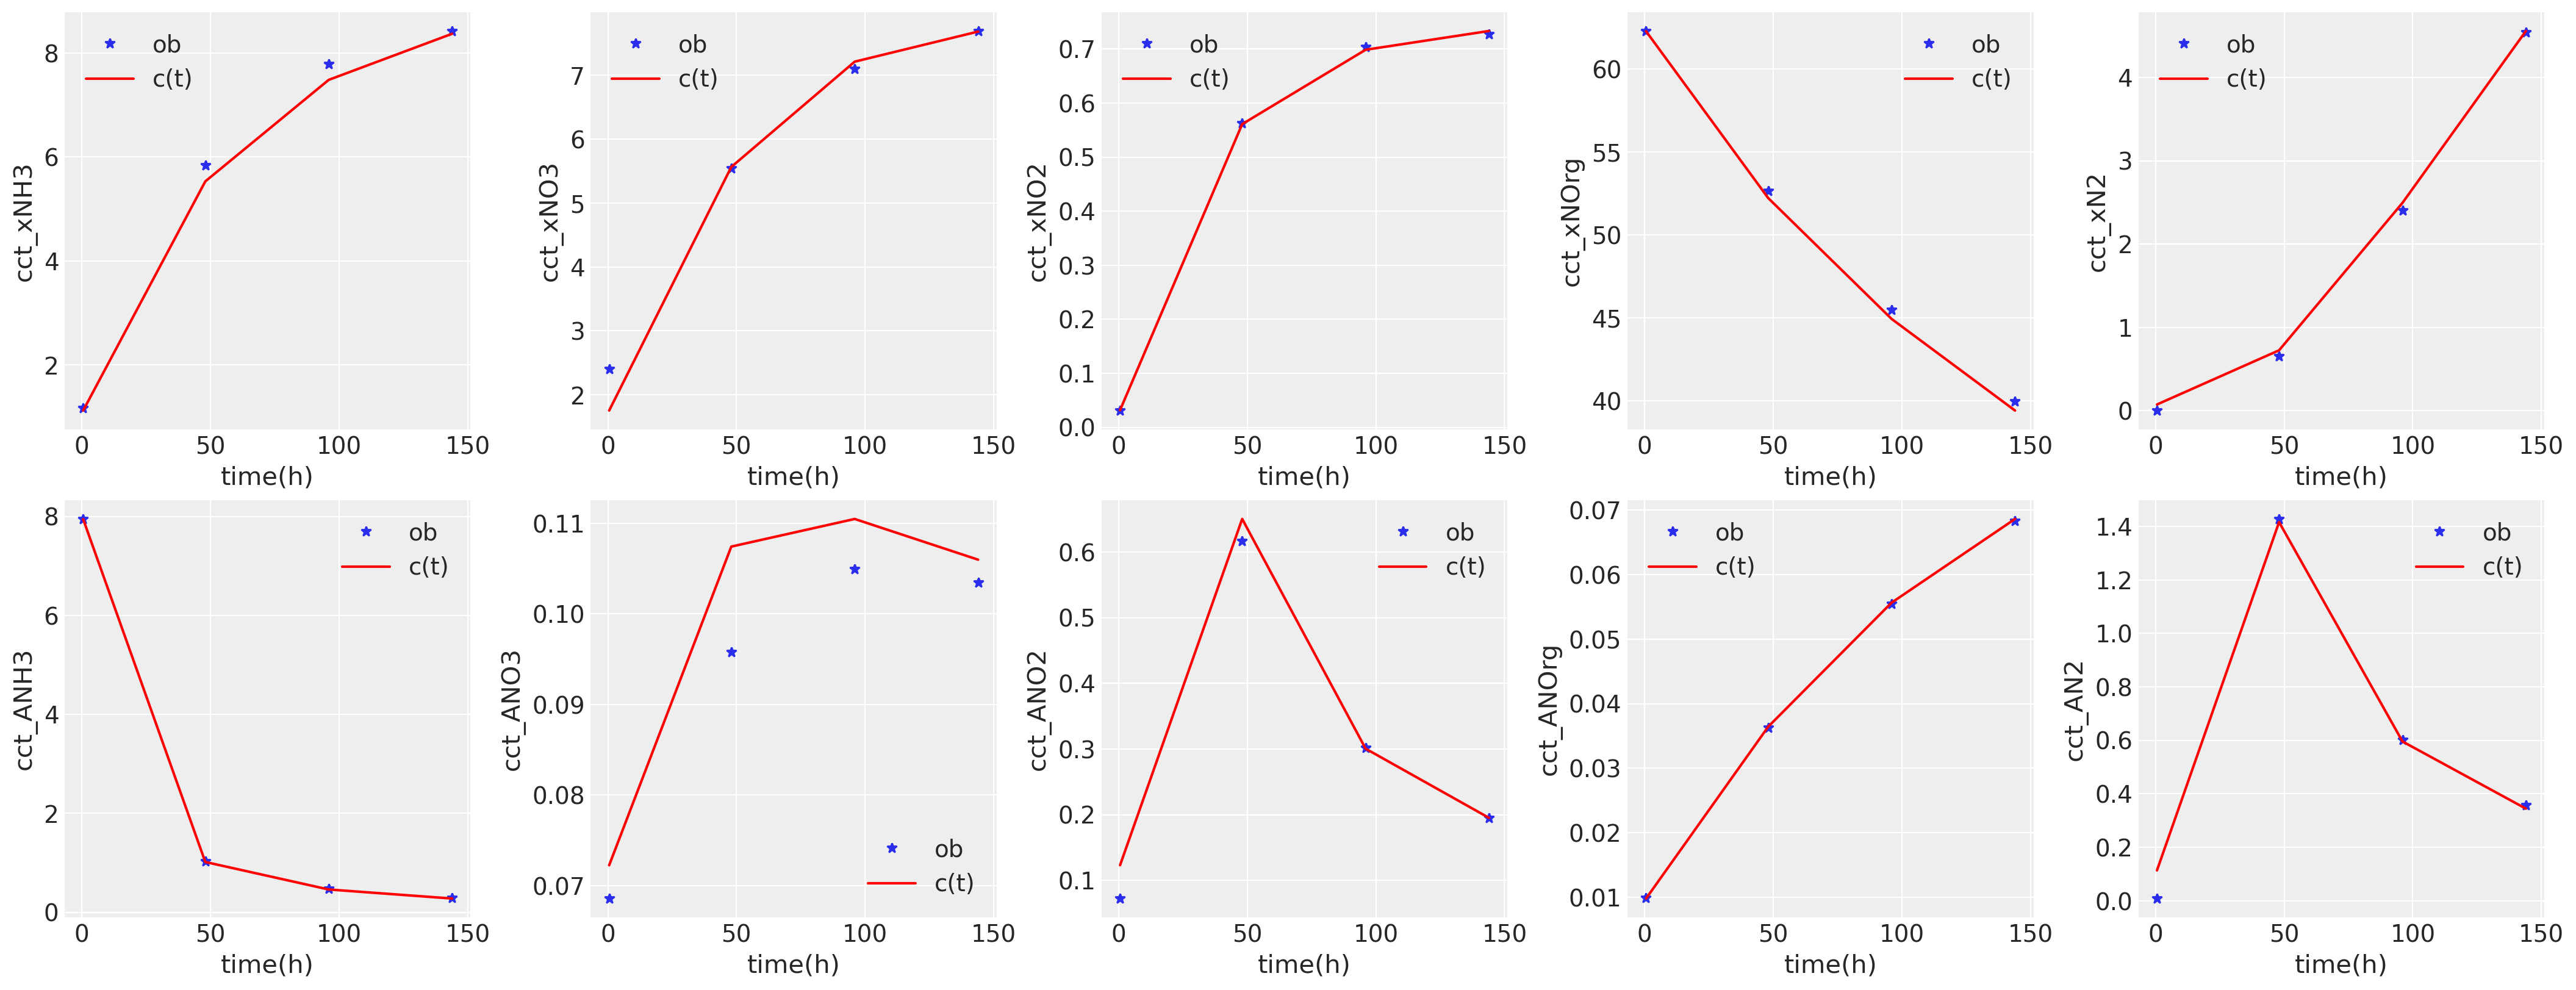

/Users/izhangxm/WorkStation/VSCode/N15Tracing/core_lib/data.py:247: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


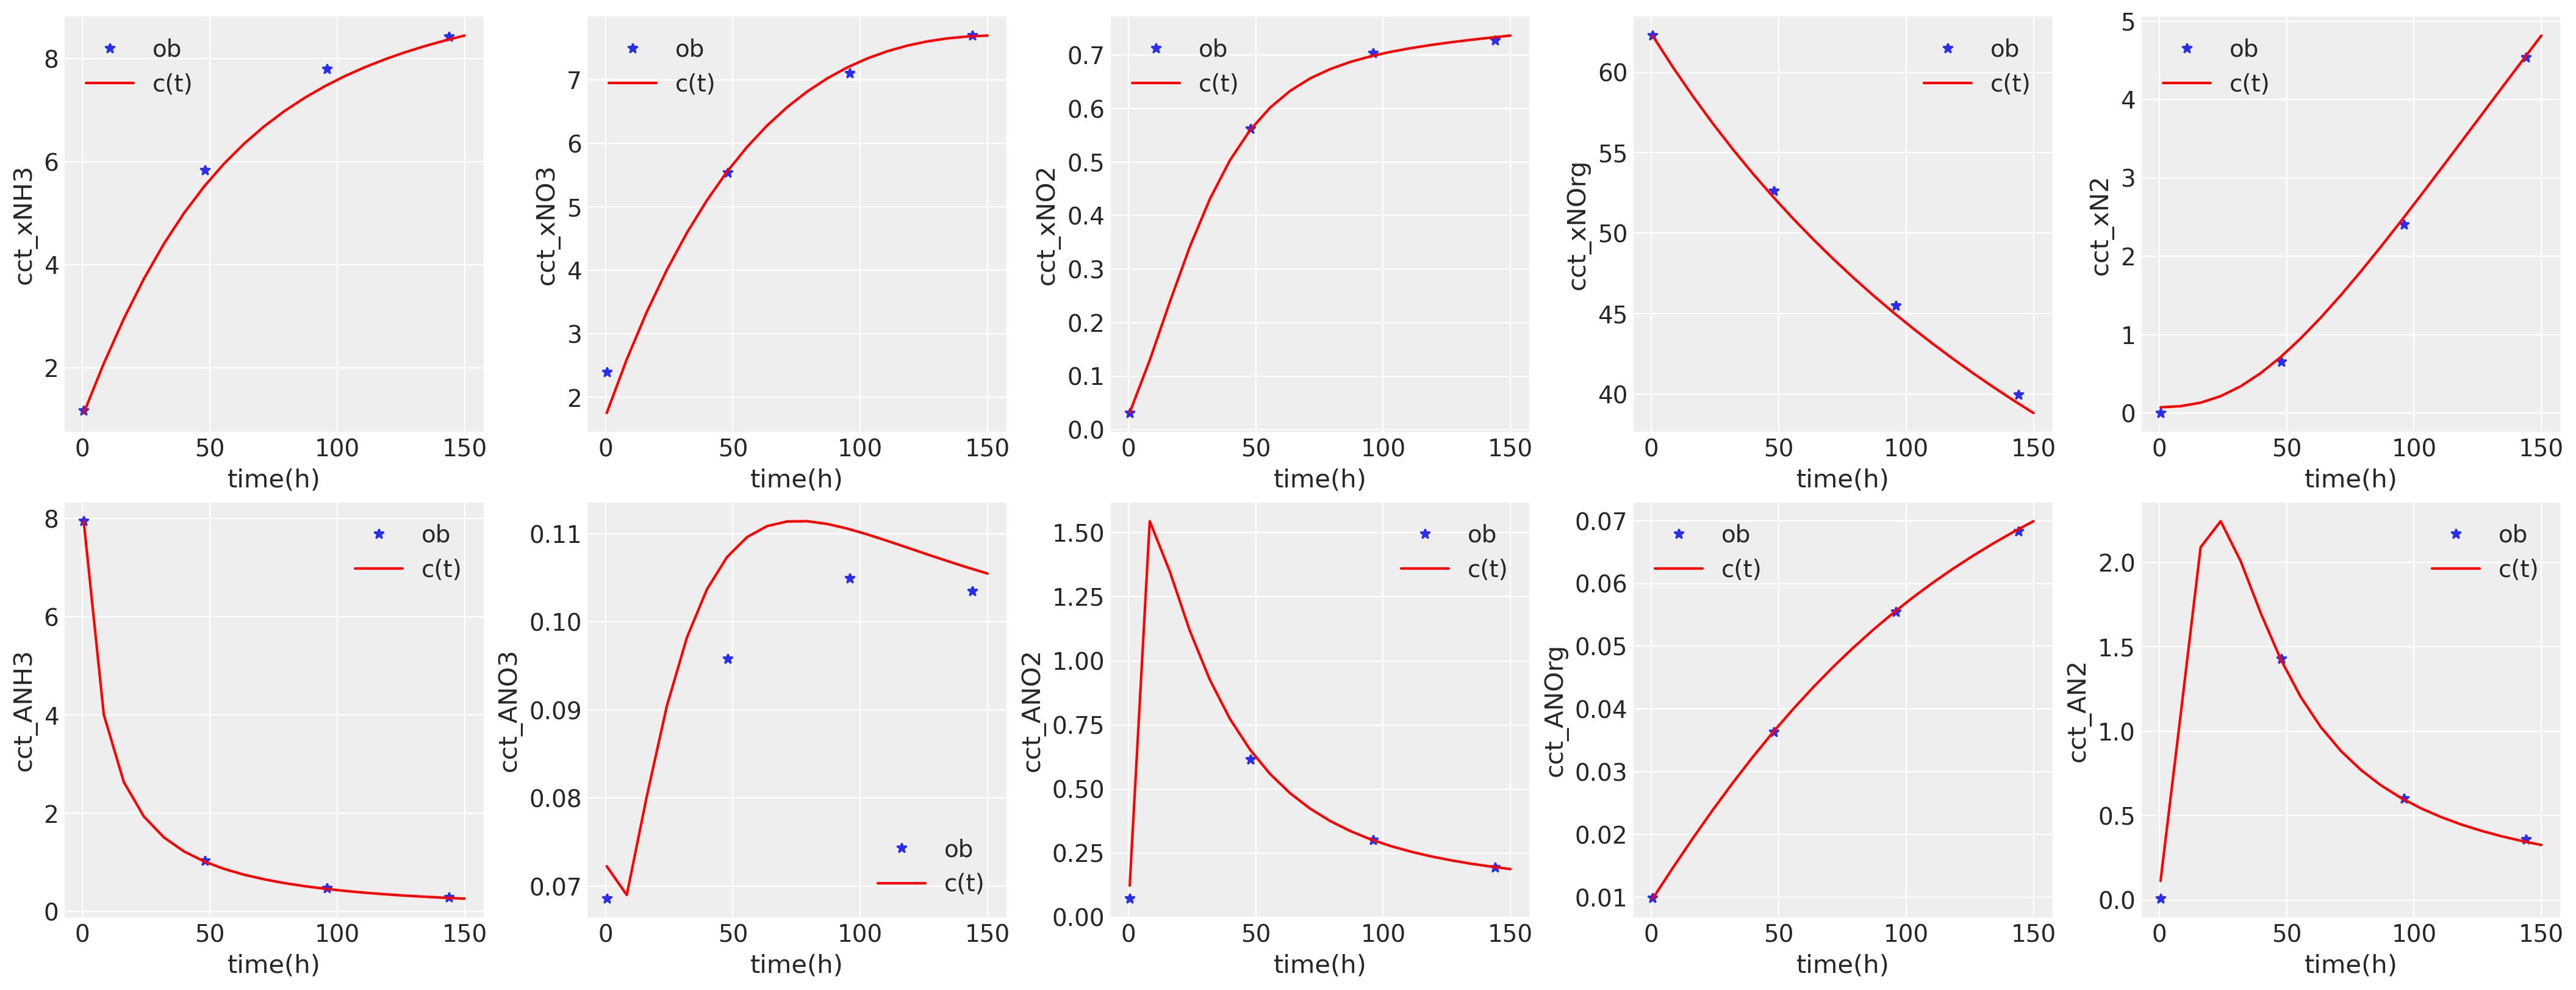

In [10]:
from core_lib import get_predict_ks, r2_loss, get_predict_starts

ks_predict = get_predict_ks(idata_lv)
pred_s = get_predict_starts(cct_names,idata_lv)

k_kinetics = np.repeat(1, 11).astype(np.uint8)
t_eval = np.array([0.5, 48, 96, 144])

dataset_new = MyDataset(db_csv_path)
cct_names, error_names = dataset_new.get_var_col_names()
gt_s = dataset_new.get_cct()[0]

dataset_new.set_as_sim_dataset(t_eval, pred_s, args=(ks_predict, k_kinetics))

print("r2_loss", r2_loss(dataset_new.get_cct(), dataset.get_cct()))
plot_dataset(dataset, dataset_new)

t_eval_new = np.linspace(0.5 , 150, 20)
dataset_new2 = MyDataset(db_csv_path)
dataset_new2.set_as_sim_dataset(t_eval_new, pred_s, args=(ks_predict, k_kinetics))
plot_dataset(dataset, dataset_new2)